In [1]:
# %%
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())


启用分片模式： True
可用设备： [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [2]:

# %%
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group, C
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree
from netket.nn.blocks import SymmExpSum


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from einops import rearrange
from netket.nn import log_cosh

# ----------------------------------------------
# 1. Convolutional Embedding：将2D自旋构型嵌入为 Token 序列
# ----------------------------------------------
class ConvEmbedding(nn.Module):
    d_model: int      # 输出通道数（嵌入维度）
    patch_size: int   # patch 尺寸

    def setup(self):
        self.conv = nn.Conv(
            features=self.d_model,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=jnp.float64,
            dtype=jnp.float64
        )

    def __call__(self, x):
        # x shape: [batch, L, L, channels]，这里 channels=1
        x = self.conv(x)  # 输出 shape: [batch, L//patch, L//patch, d_model]
        batch, H, W, _ = x.shape
        tokens = x.reshape(batch, H * W, self.d_model)
        return tokens

# ----------------------------------------------
# 2. ConvUnit：利用卷积捕获局部特征
# ----------------------------------------------
class ConvUnit(nn.Module):
    d_model: int

    @nn.compact
    def __call__(self, x):
        # 输入 x shape: [batch, n_tokens, d_model]
        batch, n_tokens, d_model = x.shape
        grid = int(np.sqrt(n_tokens))
        x_grid = x.reshape(batch, grid, grid, d_model)
        conv_out = nn.Conv(
            features=self.d_model,
            kernel_size=(3, 3),
            padding="SAME",
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=jnp.float64,
            dtype=jnp.float64
        )(x_grid)
        conv_out = nn.gelu(conv_out)
        out = conv_out.reshape(batch, n_tokens, self.d_model)
        return out

# ----------------------------------------------
# 3. CT_MHSA：带相对位置编码的多头自注意力模块
# ----------------------------------------------
class CT_MHSA(nn.Module):
    d_model: int
    h: int         # 注意力头数
    n_tokens: int  # Token 数（应为完全平方数）
    
    def setup(self):
        self.d_head = self.d_model // self.h
        self.WQ = nn.Dense(self.d_model,
                           kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64,
                           dtype=jnp.float64)
        self.WK = nn.Dense(self.d_model,
                           kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64,
                           dtype=jnp.float64)
        self.WV = nn.Dense(self.d_model,
                           kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64,
                           dtype=jnp.float64)
        # Relative positional encoding, shape: [h, n_tokens, n_tokens]
        self.P = self.param("RPE", nn.initializers.xavier_uniform(),
                            (self.h, self.n_tokens, self.n_tokens), jnp.float64)
        self.WO = nn.Dense(self.d_model,
                           kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64,
                           dtype=jnp.float64)

    def __call__(self, x):
        batch, n, _ = x.shape
        Q = self.WQ(x)
        K = self.WK(x)
        V = self.WV(x)
        Q = rearrange(Q, 'b n (h d) -> b h n d', h=self.h)
        K = rearrange(K, 'b n (h d) -> b h n d', h=self.h)
        V = rearrange(V, 'b n (h d) -> b h n d', h=self.h)
        scale = np.sqrt(self.d_head)
        attn_scores = jnp.einsum('bhid,bhjd->bhij', Q, K) / scale
        attn_scores = attn_scores + self.P
        attn = nn.softmax(attn_scores, axis=-1)
        attn_out = jnp.einsum('bhij,bhjd->bhid', attn, V)
        attn_out = rearrange(attn_out, 'b h n d -> b n (h d)')
        out = self.WO(attn_out)
        return out

# ----------------------------------------------
# 4. IRFFN：Inverted Residual Feed-Forward Network
# ----------------------------------------------
class IRFFN(nn.Module):
    d_model: int
    expansion_factor: int = 2

    @nn.compact
    def __call__(self, x):
        batch, n_tokens, _ = x.shape
        expanded_dim = self.expansion_factor * self.d_model
        hidden = nn.Dense(expanded_dim,
                          kernel_init=nn.initializers.xavier_uniform(),
                          param_dtype=jnp.float64,
                          dtype=jnp.float64)(x)
        hidden = nn.gelu(hidden)
        grid = int(np.sqrt(n_tokens))
        hidden = hidden.reshape(batch, grid, grid, expanded_dim)
        hidden = nn.Conv(
            features=expanded_dim,
            kernel_size=(3, 3),
            padding="SAME",
            feature_group_count=expanded_dim,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=jnp.float64,
            dtype=jnp.float64
        )(hidden)
        hidden = nn.gelu(hidden)
        hidden = hidden.reshape(batch, n_tokens, expanded_dim)
        out = nn.Dense(self.d_model,
                       kernel_init=nn.initializers.xavier_uniform(),
                       param_dtype=jnp.float64,
                       dtype=jnp.float64)(hidden)
        return out

# ----------------------------------------------
# 5. FBlock：RevBlock 内部分支1（卷积单元 + CT_MHSA）
# ----------------------------------------------
class FBlock(nn.Module):
    d_model: int    # 该分支通道数，应为整体 d_model/2
    h: int
    n_tokens: int

    @nn.compact
    def __call__(self, x):
        h1 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(x)
        h1 = ConvUnit(self.d_model)(h1)
        h1 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(h1)
        h1 = CT_MHSA(self.d_model, self.h, self.n_tokens)(h1)
        return h1

# ----------------------------------------------
# 6. GBlock：RevBlock 内部分支2（IRFFN 模块）
# ----------------------------------------------
class GBlock(nn.Module):
    d_model: int  # 该分支通道数，应为整体 d_model/2

    @nn.compact
    def __call__(self, x):
        h2 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(x)
        h2 = IRFFN(self.d_model)(h2)
        return h2

# ----------------------------------------------
# 7. RevBlock：可逆残差块，将输入分通道更新
# ----------------------------------------------
class RevBlock(nn.Module):
    d_model: int  # overall d_model（必须为偶数）
    h: int
    n_tokens: int

    def setup(self):
        # 内部分支各处理 d_model/2 通道
        self.f = FBlock(d_model=self.d_model // 2, h=self.h, n_tokens=self.n_tokens)
        self.g = GBlock(d_model=self.d_model // 2)

    def __call__(self, x):
        # x: [batch, n_tokens, d_model]
        x1, x2 = jnp.split(x, 2, axis=-1)
        y1 = x1 + self.f(x2)
        y2 = x2 + self.g(y1)
        return jnp.concatenate([y1, y2], axis=-1)

# ----------------------------------------------
# 8. OutputHead：汇聚 Token 后输出复数波函数振幅
# ----------------------------------------------
class OutputHead(nn.Module):
    d_model: int

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm0 = nn.LayerNorm(use_scale=True, use_bias=True,
                                  dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm1 = nn.LayerNorm(use_scale=True, use_bias=True,
                                  dtype=jnp.float64, param_dtype=jnp.float64)
        self.output_layer0 = nn.Dense(self.d_model,
                                      kernel_init=nn.initializers.xavier_uniform(),
                                      bias_init=nn.initializers.zeros,
                                      param_dtype=jnp.float64,
                                      dtype=jnp.float64)
        self.output_layer1 = nn.Dense(self.d_model,
                                      kernel_init=nn.initializers.xavier_uniform(),
                                      bias_init=nn.initializers.zeros,
                                      param_dtype=jnp.float64,
                                      dtype=jnp.float64)

    def __call__(self, x):
        z = self.out_layer_norm(x.sum(axis=1))
        amp = self.norm0(self.output_layer0(z))
        sign = self.norm1(self.output_layer1(z))
        out = amp + 1j * sign
        return jnp.sum(log_cosh(out), axis=-1)

# ----------------------------------------------
# 9. OptimalNQS：最终综合设计的架构
# ----------------------------------------------
class CTWFNQS(nn.Module):
    num_layers: int     # RevBlock 层数（例如4～8层）
    d_model: int        # 总通道数（须为偶数，建议32～48）
    heads: int          # 注意力头数（例如4～8）
    n_sites: int        # 总格点数，例如 L x L，n_sites=L^2
    patch_size: int     # patch 尺寸

    def setup(self):
        # 系统边长 L
        self.L = int(np.sqrt(self.n_sites))
        # 每边 token 数 = L // patch_size，token 总数
        self.n_tokens_side = self.L // self.patch_size
        self.n_tokens = self.n_tokens_side * self.n_tokens_side
        self.embedding = ConvEmbedding(d_model=self.d_model, patch_size=self.patch_size)
        # 堆叠多个可逆残差块
        self.rev_blocks = [RevBlock(d_model=self.d_model, h=self.heads, n_tokens=self.n_tokens)
                           for _ in range(self.num_layers)]
        self.output = OutputHead(d_model=self.d_model)

    def __call__(self, spins):
        # spins: [batch, n_sites]，一维数组后 reshape 成 [batch, L, L, 1]
        x = jnp.atleast_2d(spins)
        batch = x.shape[0]
        x = x.reshape(batch, self.L, self.L, 1)
        x = self.embedding(x)  # [batch, n_tokens, d_model]
        for block in self.rev_blocks:
            x = block(x)
        out = self.output(x)
        return out

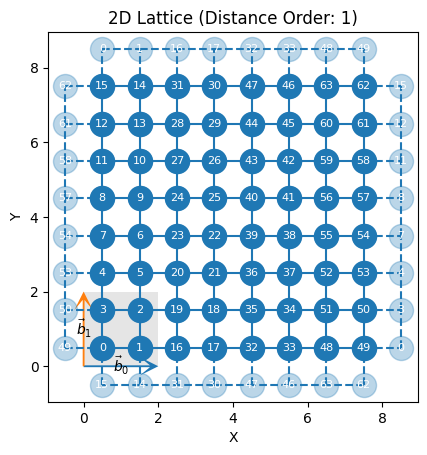

In [ ]:
# 哈密顿量参数
J1 = 0.03
J2 = 0.0
Q = 1.0  # 四自旋相互作用强度，替换h项

# Shastry-Sutherland晶格定义
Lx = 4
Ly = 4

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# 定义(Si·Sj - 1/4)算符
ProjOp = jnp.array(SiSj) - 0.25 * jnp.array(umum)
ProjOp2 = jnp.kron(ProjOp, ProjOp)

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hilbert, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hilbert, dtype=jnp.complex128)

# 获取晶格尺寸
Lx, Ly = lattice.extent[0], lattice.extent[1]

# 遍历所有单元格
for x in range(Lx):
    for y in range(Ly):
        # 计算当前单元格的基本索引
        base = 4 * (y + x * Ly)
        
        # 当前单元格内的四个格点
        site0 = base      # 左下角 (0.5, 0.5)
        site1 = base + 1  # 右下角 (1.5, 0.5)
        site2 = base + 2  # 右上角 (1.5, 1.5)
        site3 = base + 3  # 左上角 (0.5, 1.5)
        
        # 找到相邻单元格（考虑周期性边界条件）
        right_x = (x + 1) % Lx
        right_base = 4 * (y + right_x * Ly)
        
        left_x = (x - 1 + Lx) % Lx
        left_base = 4 * (y + left_x * Ly)
        
        up_y = (y + 1) % Ly
        up_base = 4 * (up_y + x * Ly)
        
        down_y = (y - 1 + Ly) % Ly
        down_base = 4 * (down_y + x * Ly)
        
        # 1. 单元格内部的水平方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site1, site3, site2]])
        
        # 2. 单元格内部的垂直方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site3, site1, site2]])
        
        # 3. 与右侧单元格形成的水平plaquette（处理x方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site1, right_base, site2, right_base + 3]])
        
        # 4. 与上方单元格形成的垂直plaquette（处理y方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site3, up_base, site2, up_base + 1]])
        
        # # 5. 与左侧单元格形成的水平plaquette（处理x方向周期性）
        # H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
        #                              [[site0, left_base + 1, site3, left_base + 2]])
        
        # # 6. 与下方单元格形成的垂直plaquette（处理y方向周期性）
        # H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
        #                              [[site0, down_base + 3, site1, down_base + 2]])

# 合并两部分哈密顿量
hamiltonian = H_J + 2*H_Q
hamiltonian = hamiltonian.to_jax_operator()


In [5]:
# ----------------- 构造CTWF量子态 -----------------
# 这里设置 patch_size 为2，令 L_eff = n_sites / (2^2)。对于Shastry-Sutherland晶格，
# n_sites = Lx * Ly * 4 = 36 -> L_eff = 9。
# 按照论文参数：d_model=18, h=2，且堆叠1层CTWF Block
# 使用增强位置编码的方式初始化CTWF模型
# 例如，使用2D位置编码：

model_no_symm = CTWFNQS(
    num_layers=4,
    d_model=32,
    heads=4,
    n_sites=lattice.n_nodes,
    patch_size=2
)


# 对称化（这里采用平移及旋转对称性）
nc = 4
cyclic_4 = PointGroup(
    [Identity()] + [rotation((360 / nc)*i) for i in range(1, nc)],
    ndim=2,
)
C4v = glide_group(trans=(1, 1), origin=(0, 0)) @ cyclic_4
C4v_symmetry = lattice.space_group(C4v)
# # 平移对称性
# trans_symmetry = lattice.translation_group()

# D4对称性
d4_group = D(4)

# 定义新的对称中心
new_origin = np.array([1.0, 1.0])

# 调整对称群，以 new_origin 为新的旋转中心
new_d4_group = d4_group.change_origin(new_origin)
D4_symmetry = lattice.point_group(new_d4_group)


symmetries=C4v_symmetry
print(f"Number of symmetry operations: {len(symmetries)}")


from netket.nn.blocks import SymmExpSum
model = SymmExpSum(
    module=model_no_symm,
    symm_group=symmetries,
    character_id=None
)


Number of symmetry operations: 128


In [ ]:
# ----------------- 训练设置 -----------------
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=lattice, n_chains=2**12, d_max=2)

# 使用MCState构造变分量子态
vqs = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=2**12,
    n_samples_per_rank=None,
    n_discard_per_chain=0,
    chunk_size=2**8,
    training_kwargs={"holomorphic": False}  # 非全纯函数
)

n_params = nk.jax.tree_size(vqs.parameters)
print(f"Number of model parameters: {n_params}")  # 应接近7884

Number of model parameters: 26144


In [ ]:

# %%
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
# ...existing code...
def clip_gradients(gradients, max_norm):
    # 将梯度中的叶子节点转换为列表
    grads_flat, tree_def = jax.tree_util.tree_flatten(gradients)
    # 计算全局范数
    global_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in grads_flat]))
    # 计算裁切系数
    clip_coef = jnp.minimum(1.0, max_norm / (global_norm + 1e-6))
    # 应用裁切
    return jax.tree_util.tree_map(lambda g: g * clip_coef, gradients)

class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature
        self.max_grad_norm = 1.0  # 最大范数，可以根据需要进行调整

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples

        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = jax.tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)

        # 自由能梯度：能量梯度减去熵梯度
        total_grad = jax.tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)

        # 对梯度进行裁切
        total_grad = clip_gradients(total_grad, self.max_grad_norm)

        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state
# ...existing code...


# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self
    


temperature_original = 1.0  # 初始温度
reference_energy = -16.2618
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
# optimizer = nk.optimizer.Adam(learning_rate=0.0005)



vmc = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=temperature_original,
    hamiltonian=hamiltonian,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs
)

start = time.time()
vmc.run(n_iter=1000)
end = time.time()
print(f"优化耗时: {end - start:.2f}秒")

2025-04-15 06:32:14.933826: W external/xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:863] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2025-04-15 06:32:14.933860: W external/xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:866] Conv: %cudnn-conv-bias-activation.16 = (f64[524288,16,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f64[524288,16,4,4]{3,2,1,0} %bitcast.5293, f64[16,16,3,3]{3,2,1,0} %bitcast.5300, f64[16]{0} %bitcast.5302), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_name="jit(_reset)/jit(main)/SymmExpSum/module/rev_blocks_0/f/ConvUnit_0/Conv_0/conv_general_dilated" source_file="/home/users/ntu/s240076/.local/lib/python3.10/site-packages/flax/linen/linear.py" source_line=658}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"

Lx=4, Ly=4:   0%|          | 0/1000 [00:00<?, ?it/s]